In [1]:
import datetime as dt
import pandas_datareader.data as web
from matplotlib import style
import matplotlib.pyplot as plt
import math 
import numpy as np
import yfinance as yf
import pandas as pd
from scipy import optimize as scopti
import bs4 as bs
import pickle
import requests
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import data
import risk_metrics as rm
import markowitz_construction as mc
import cppi_strategy_backtest as cppi

## Extracting T-Rates from Fred Api

In [3]:
yields=pd.read_csv('fred_us_termstructure.csv',index_col=['DATE']).fillna(method='bfill')
yields.index=pd.to_datetime(yields.index, format='%d-%m-%Y')

In [4]:
yieldchanges=yields.diff(periods=1).dropna()

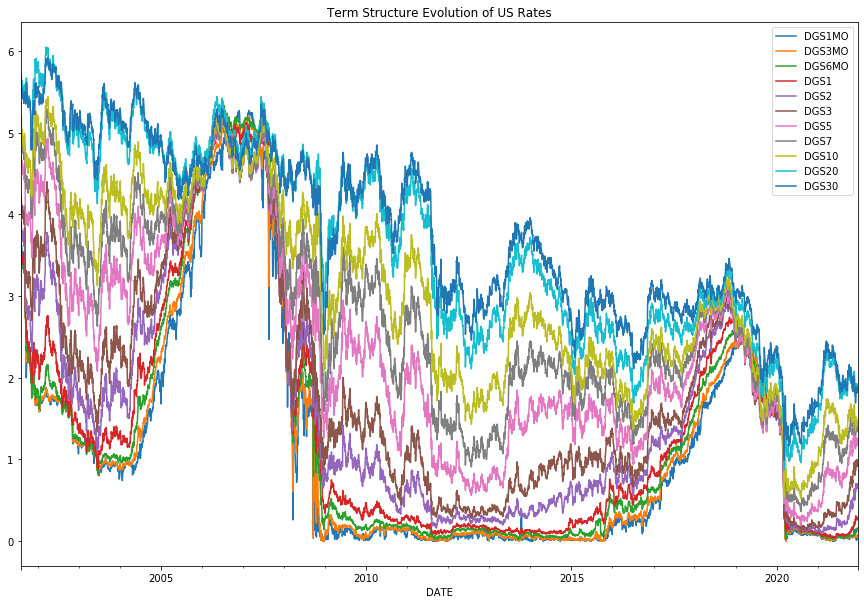

In [5]:
yields.plot(figsize=(15,10), title='Term Structure Evolution of US Rates')

## Dividing into periods:
### period1= 2001-2004
### period2= 2004-2010
### period3= 2010-2015
### period4= 2015- Present

## Consider 2001-2004 period

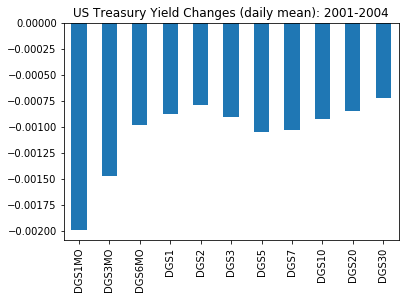

In [8]:
yieldchanges['2001':'2004'].mean().plot(kind='bar', title ='US Treasury Yield Changes (daily mean): 2001-2004')

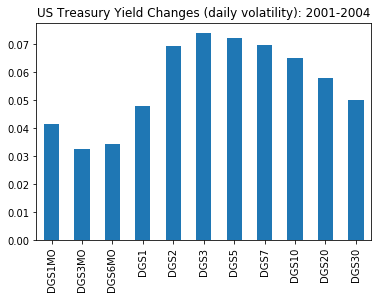

In [9]:
yieldchanges['2001':'2004'].std().plot(kind='bar', title ='US Treasury Yield Changes (daily volatility): 2001-2004')

### Yield Changes Correlation in 2001-2004

In [10]:
yieldchanges['2001':'2004'].corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.705074,0.553250,0.392992,0.285785,0.261738,0.231832,0.192646,0.168375,0.109590,0.086576
DGS3MO,0.705074,1.000000,0.844390,0.618012,0.492543,0.461134,0.412980,0.354181,0.323769,0.248784,0.207563
DGS6MO,0.553250,0.844390,1.000000,0.857174,0.716371,0.677658,0.616864,0.562056,0.526513,0.444463,0.373605
DGS1,0.392992,0.618012,0.857174,1.000000,0.878028,0.838274,0.787234,0.746387,0.712101,0.642684,0.534103
DGS2,0.285785,0.492543,0.716371,0.878028,1.000000,0.974302,0.923419,0.889743,0.852666,0.783595,0.652161
DGS3,0.261738,0.461134,0.677658,0.838274,0.974302,1.000000,0.956485,0.926937,0.895808,0.829219,0.702562
DGS5,0.231832,0.412980,0.616864,0.787234,0.923419,0.956485,1.000000,0.977371,0.959196,0.908110,0.784777
DGS7,0.192646,0.354181,0.562056,0.746387,0.889743,0.926937,0.977371,1.000000,0.981286,0.948453,0.830925
DGS10,0.168375,0.323769,0.526513,0.712101,0.852666,0.895808,0.959196,0.981286,1.000000,0.966006,0.867219
DGS20,0.109590,0.248784,0.444463,0.642684,0.783595,0.829219,0.908110,0.948453,0.966006,1.000000,0.894993


In [11]:
#eigen_values,eigen_vectors=np.linalg.eig(yieldchanges['2001':'2005'].corr())
#eigen_vectors=-1*eigen_vectors.T
#idx = eigen_values.argsort()[::-1]   
#eigen_values = eigen_values[idx]
#eigen_vectors = eigen_vectors[:,idx]
#explained_variance=eigen_values/eigen_values.sum()
pca=PCA()
yields_transformed=pca.fit_transform(yieldchanges['2001':'2004'])
eigen_vectors=pca.components_
eigen_values=pca.explained_variance_
pca_transformed_yield=pd.DataFrame(yields_transformed,
                                   columns=range(1,eigen_values.shape[0]+1,1),
                                   index=yieldchanges['2001':'2004'].index)

In [12]:
eigen_values_cumulative=pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
                                     index=range(1,eigen_values.shape[0]+1,1), columns=['Expained Var'])
eigen_values_cumulative

,Expained Var
1,0.821035
2,0.914349
3,0.952581
4,0.969895
5,0.979541
6,0.987581
7,0.991654
8,0.994126
9,0.996359
10,0.998310


In [13]:
eigen_df=pd.DataFrame(eigen_vectors.T,index=yieldchanges.columns, columns=range(1,eigen_values.shape[0]+1,1))

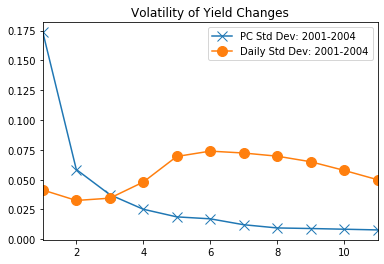

In [14]:
pca_transformed_yield.std().plot(marker='x',markersize=10,label='PC Std Dev: 2001-2004',
                                                         title='Volatility of Yield Changes')
pd.Series(yieldchanges['2001':'2004'].std().values,index=range(1,
                                                               eigen_values.shape[0]+1,1)).plot(marker='o',
                                                                                                markersize=10,
                                                                                                label='Daily Std Dev: 2001-2004'
                                                                                               )
plt.legend()

### PC Loadings of T yeild changes for 2001-2004

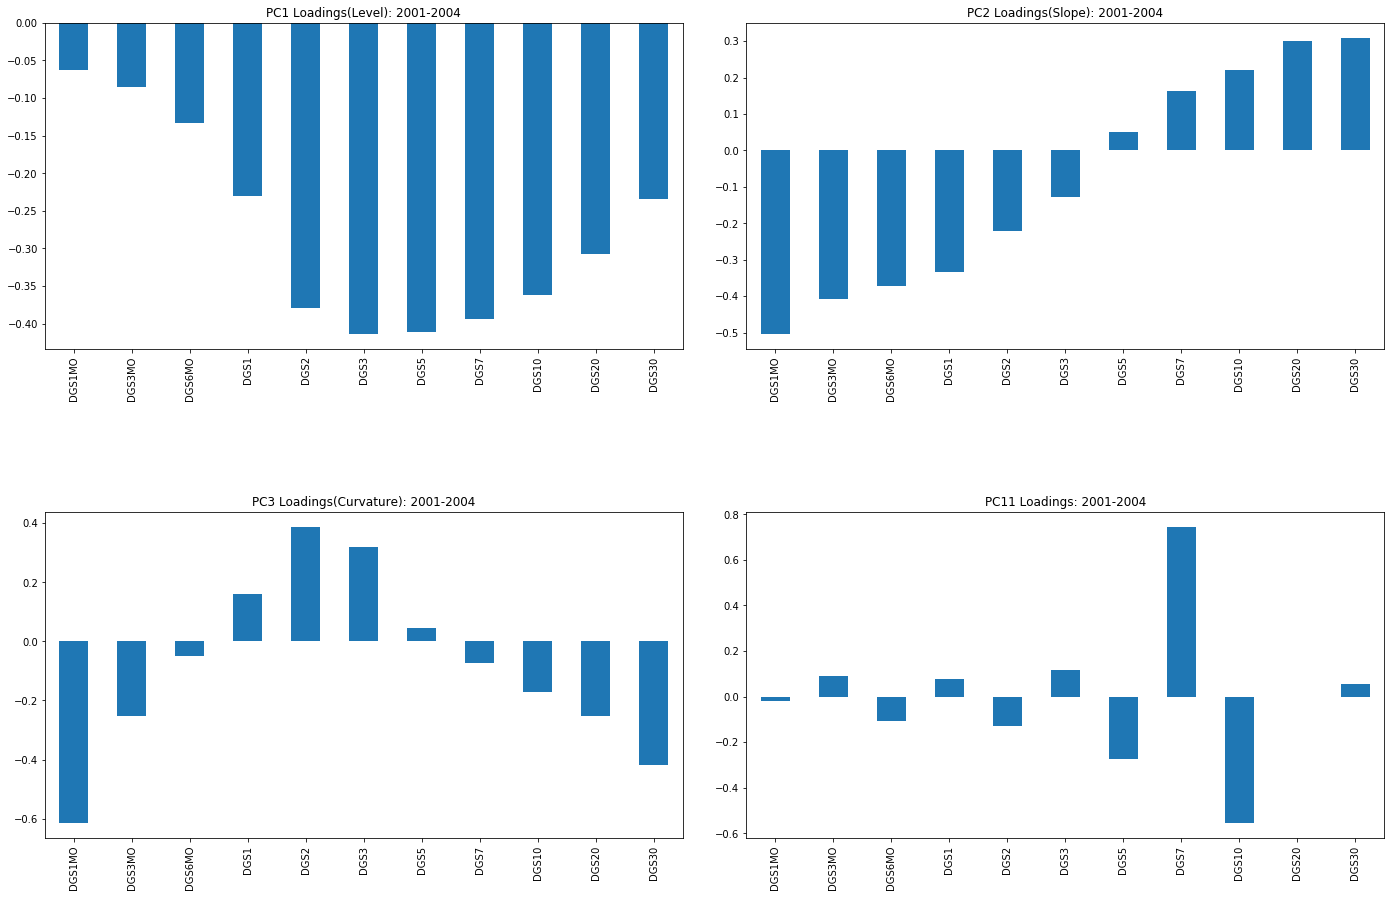

In [15]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(24,15))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
eigen_df[1].plot(ax=ax[0,0],kind="bar",title='PC1 Loadings(Level): 2001-2004')
eigen_df[2].plot(ax=ax[0,1],kind="bar",title='PC2 Loadings(Slope): 2001-2004')
eigen_df[3].plot(ax=ax[1,0],kind="bar",title='PC3 Loadings(Curvature): 2001-2004')
eigen_df[11].plot(ax=ax[1,1],kind="bar",title='PC11 Loadings: 2001-2004')

### The first principal component variable is a weighted average of all the yield changes, giving highest weight to the 5-year tenor
### The second principal component measures the spread between long-tenor and short-tenor yields
### The third principal component variable measures the curvature in the yield curve
### The last (11th) principal component variable measures the ‘hedge’ of the 7-year yield with the 5-year and 10-year yields

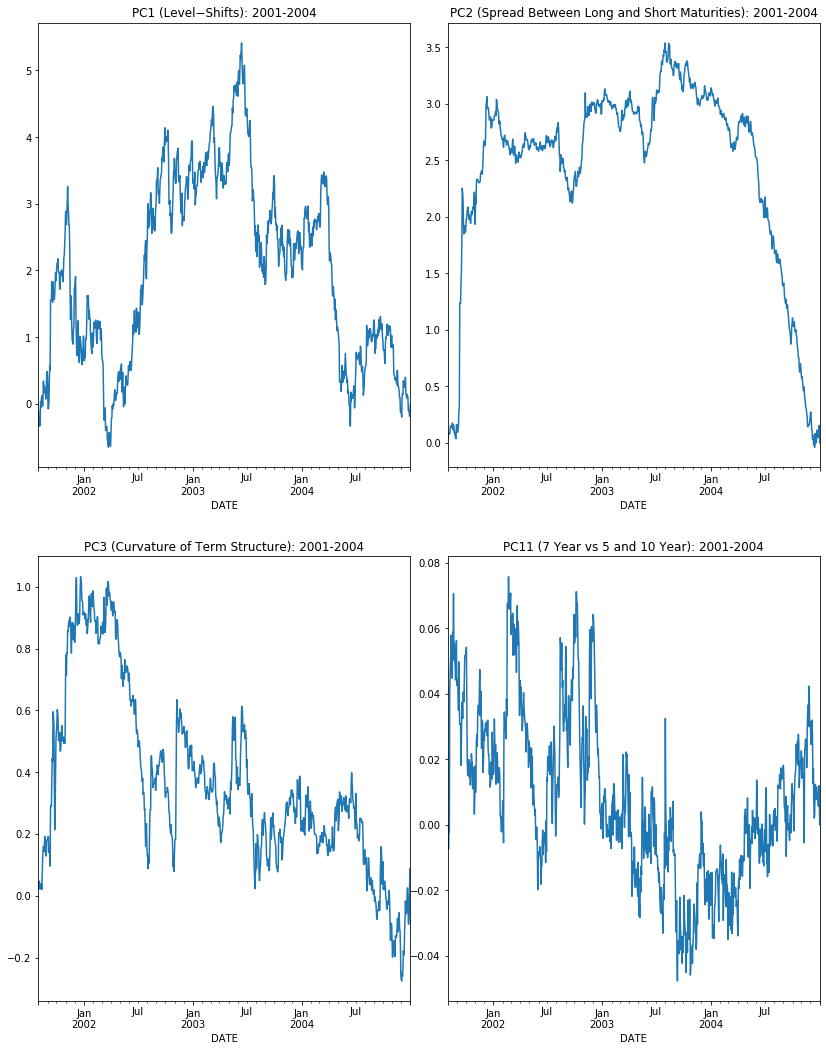

In [16]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(14,18))
plt.subplots_adjust(wspace=0.1,hspace=0.2)
pca_transformed_yield[1].cumsum().plot(ax=ax[0,0],title='PC1 (Level−Shifts): 2001-2004')
pca_transformed_yield[2].cumsum().plot(ax=ax[0,1],title='PC2 (Spread Between Long and Short Maturities): 2001-2004')
pca_transformed_yield[3].cumsum().plot(ax=ax[1,0],title='PC3 (Curvature of Term Structure): 2001-2004')
#pca_transformed_yield[10].plot(ax=ax[2,0],kind="bar",title='P10 Loadings: 2001-2005')
pca_transformed_yield[11].cumsum().plot(ax=ax[1,1],title='PC11 (7 Year vs 5 and 10 Year): 2001-2004')

## Consider 2004-2010 period

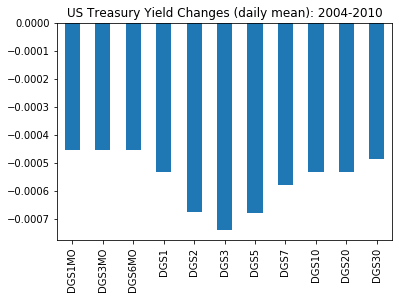

In [17]:
yieldchanges['2004':'2010'].mean().plot(kind='bar', title ='US Treasury Yield Changes (daily mean): 2004-2010')

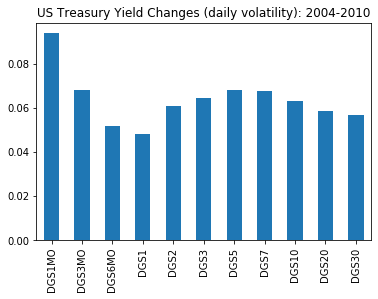

In [18]:
yieldchanges['2004':'2010'].std().plot(kind='bar', title ='US Treasury Yield Changes (daily volatility): 2004-2010')

In [19]:
yieldchanges['2004':'2010'].corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.683327,0.512036,0.469811,0.265745,0.237625,0.198798,0.173549,0.145981,0.118739,0.114074
DGS3MO,0.683327,1.000000,0.777298,0.646480,0.364494,0.334301,0.277365,0.239709,0.202716,0.159968,0.153669
DGS6MO,0.512036,0.777298,1.000000,0.866771,0.554418,0.526324,0.453681,0.403143,0.358103,0.301940,0.280513
DGS1,0.469811,0.646480,0.866771,1.000000,0.789799,0.751258,0.676715,0.613856,0.556781,0.484567,0.440137
DGS2,0.265745,0.364494,0.554418,0.789799,1.000000,0.957607,0.904161,0.841006,0.779885,0.682222,0.619683
DGS3,0.237625,0.334301,0.526324,0.751258,0.957607,1.000000,0.951617,0.905516,0.855146,0.765701,0.703975
DGS5,0.198798,0.277365,0.453681,0.676715,0.904161,0.951617,1.000000,0.973301,0.940229,0.864119,0.804015
DGS7,0.173549,0.239709,0.403143,0.613856,0.841006,0.905516,0.973301,1.000000,0.970150,0.911585,0.856548
DGS10,0.145981,0.202716,0.358103,0.556781,0.779885,0.855146,0.940229,0.970150,1.000000,0.955847,0.906651
DGS20,0.118739,0.159968,0.301940,0.484567,0.682222,0.765701,0.864119,0.911585,0.955847,1.000000,0.957658


In [20]:
pca=PCA()
yields_transformed=pca.fit_transform(yieldchanges['2004':'2010'])
eigen_vectors=pca.components_
eigen_values=pca.explained_variance_
pca_transformed_yield=pd.DataFrame(yields_transformed,
                                   columns=range(1,eigen_values.shape[0]+1,1),
                                   index=yieldchanges['2004':'2010'].index)

In [21]:
eigen_values_cumulative=pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
                                     index=range(1,eigen_values.shape[0]+1,1), columns=['Expained Var'])
eigen_df=pd.DataFrame(eigen_vectors.T,index=yieldchanges.columns, columns=range(1,eigen_values.shape[0]+1,1))
eigen_values_cumulative

,Expained Var
1,0.608430
2,0.857682
3,0.925234
4,0.964223
5,0.980368
6,0.987958
7,0.991780
8,0.994447
9,0.996934
10,0.998511


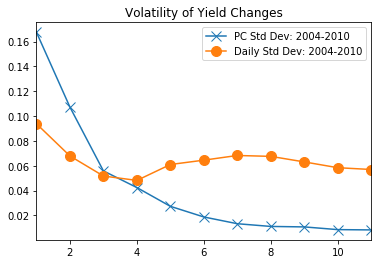

In [22]:
pca_transformed_yield.std().plot(marker='x',markersize=10,label='PC Std Dev: 2004-2010',
                                                         title='Volatility of Yield Changes')
pd.Series(yieldchanges['2004':'2010'].std().values,index=range(1,
                                                               eigen_values.shape[0]+1,1)).plot(marker='o',
                                                                                                markersize=10,
                                                                                                label='Daily Std Dev: 2004-2010'
                                                                                               )
plt.legend()

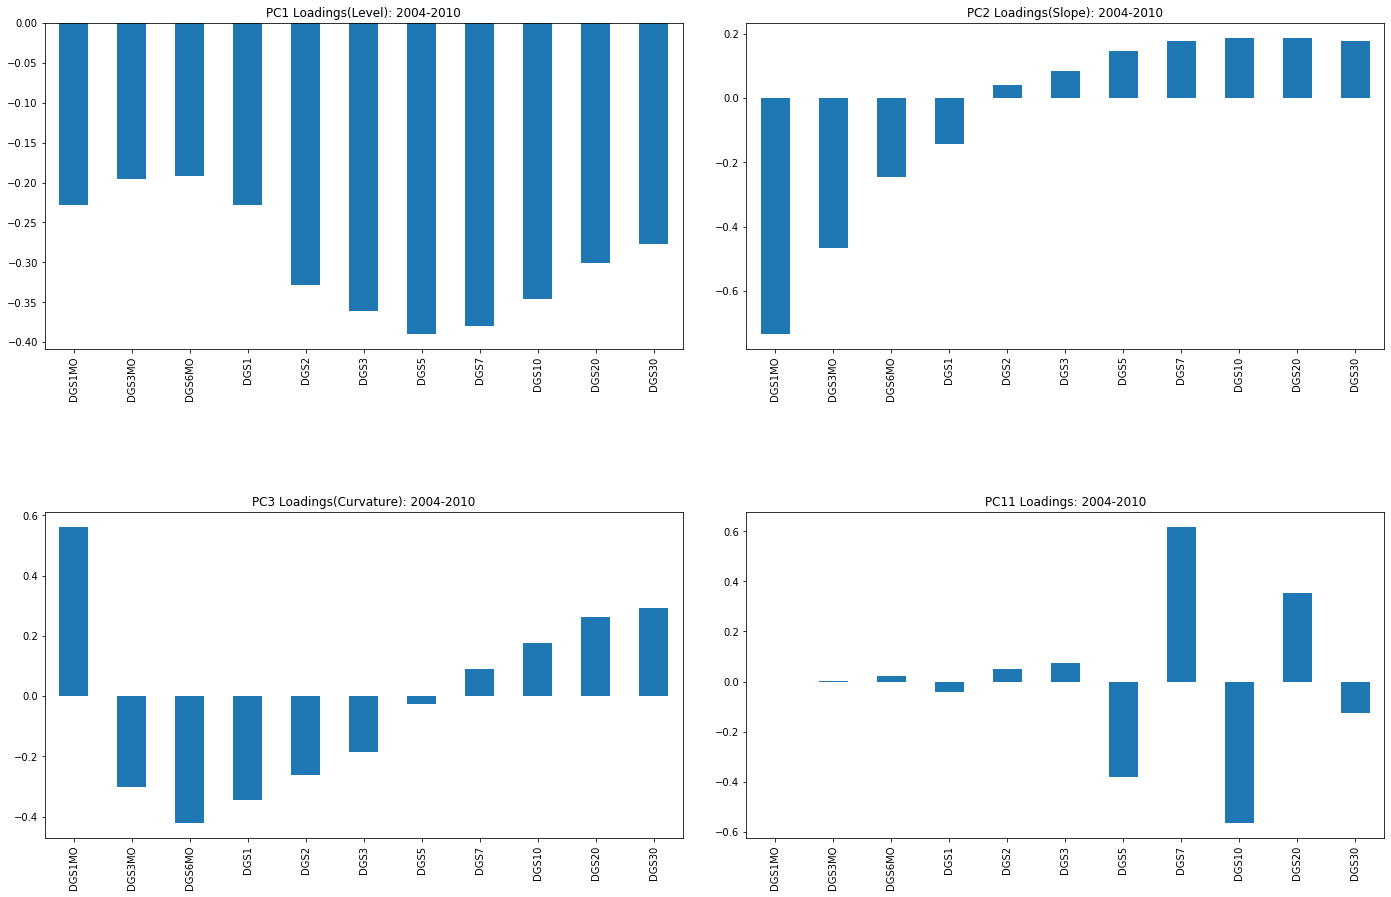

In [23]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(24,15))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
eigen_df[1].plot(ax=ax[0,0],kind="bar",title='PC1 Loadings(Level): 2004-2010')
eigen_df[2].plot(ax=ax[0,1],kind="bar",title='PC2 Loadings(Slope): 2004-2010')
eigen_df[3].plot(ax=ax[1,0],kind="bar",title='PC3 Loadings(Curvature): 2004-2010')
eigen_df[11].plot(ax=ax[1,1],kind="bar",title='PC11 Loadings: 2004-2010')

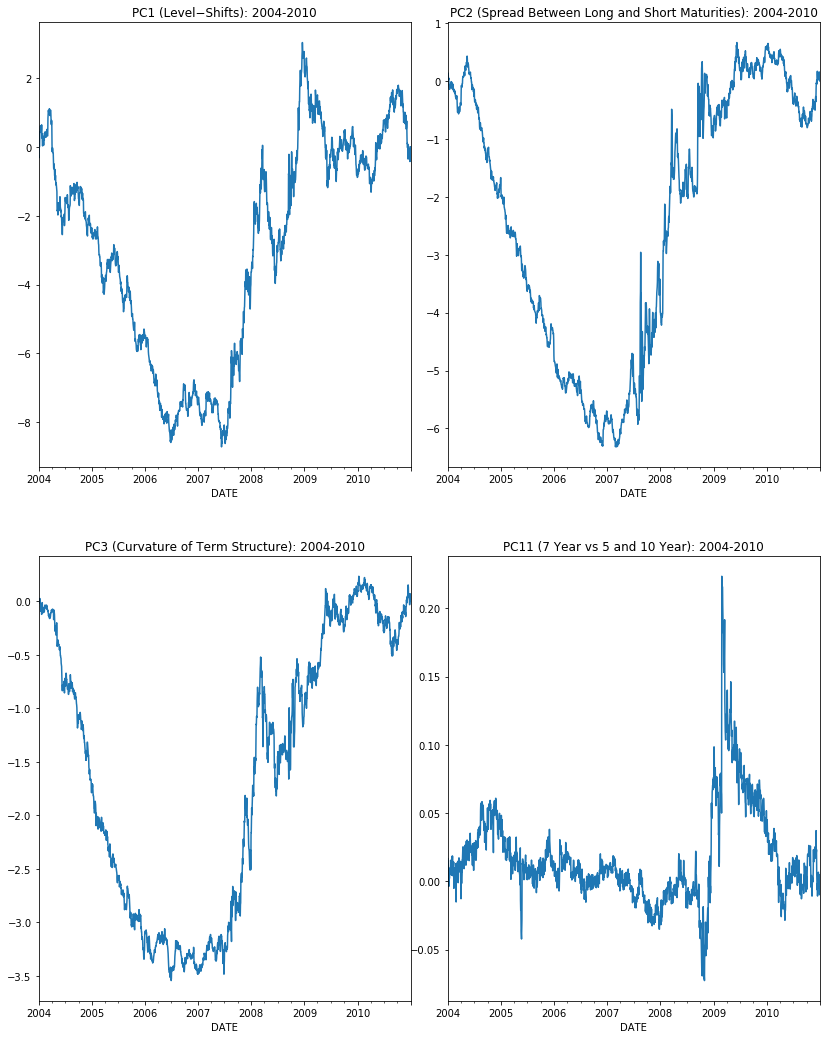

In [24]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(14,18))
plt.subplots_adjust(wspace=0.1,hspace=0.2)
pca_transformed_yield[1].cumsum().plot(ax=ax[0,0],title='PC1 (Level−Shifts): 2004-2010')
pca_transformed_yield[2].cumsum().plot(ax=ax[0,1],title='PC2 (Spread Between Long and Short Maturities): 2004-2010')
pca_transformed_yield[3].cumsum().plot(ax=ax[1,0],title='PC3 (Curvature of Term Structure): 2004-2010')
#pca_transformed_yield[10].plot(ax=ax[2,0],kind="bar",title='P10 Loadings: 2001-2005')
pca_transformed_yield[11].cumsum().plot(ax=ax[1,1],title='PC11 (7 Year vs 5 and 10 Year): 2004-2010')

## Consider 2010-2015 period

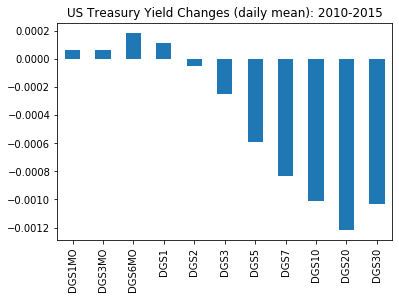

In [25]:
yieldchanges['2010':'2015'].mean().plot(kind='bar', title ='US Treasury Yield Changes (daily mean): 2010-2015')

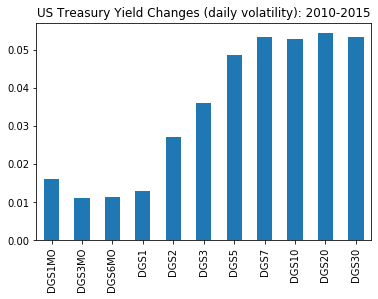

In [26]:
yieldchanges['2010':'2015'].std().plot(kind='bar', title ='US Treasury Yield Changes (daily volatility): 2010-2015')

In [27]:
yieldchanges['2010':'2015'].corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.275237,0.251149,0.188894,0.076646,0.071465,0.059791,0.058710,0.071980,0.076772,0.081181
DGS3MO,0.275237,1.000000,0.473376,0.239985,0.142912,0.134747,0.101470,0.093037,0.093071,0.078708,0.079067
DGS6MO,0.251149,0.473376,1.000000,0.394983,0.242798,0.211762,0.177238,0.160390,0.146067,0.131429,0.123005
DGS1,0.188894,0.239985,0.394983,1.000000,0.560649,0.520323,0.452723,0.406347,0.366512,0.314704,0.299756
DGS2,0.076646,0.142912,0.242798,0.560649,1.000000,0.875057,0.811414,0.738300,0.673428,0.582835,0.544460
DGS3,0.071465,0.134747,0.211762,0.520323,0.875057,1.000000,0.931700,0.868579,0.800444,0.695181,0.651181
DGS5,0.059791,0.101470,0.177238,0.452723,0.811414,0.931700,1.000000,0.968196,0.922182,0.834023,0.791401
DGS7,0.058710,0.093037,0.160390,0.406347,0.738300,0.868579,0.968196,1.000000,0.972480,0.908598,0.872564
DGS10,0.071980,0.093071,0.146067,0.366512,0.673428,0.800444,0.922182,0.972480,1.000000,0.961354,0.936673
DGS20,0.076772,0.078708,0.131429,0.314704,0.582835,0.695181,0.834023,0.908598,0.961354,1.000000,0.983961


In [28]:
pca=PCA()
yields_transformed=pca.fit_transform(yieldchanges['2010':'2015'])
eigen_vectors=pca.components_
eigen_values=pca.explained_variance_
pca_transformed_yield=pd.DataFrame(yields_transformed,
                                   columns=range(1,eigen_values.shape[0]+1,1),
                                   index=yieldchanges['2010':'2015'].index)

In [29]:
eigen_values_cumulative=pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
                                     index=range(1,eigen_values.shape[0]+1,1), columns=['Expained Var'])
eigen_df=pd.DataFrame(eigen_vectors.T,index=yieldchanges.columns, columns=range(1,eigen_values.shape[0]+1,1))
eigen_values_cumulative

,Expained Var
1,0.859652
2,0.936596
3,0.956454
4,0.969911
5,0.978599
6,0.984167
7,0.989409
8,0.993136
9,0.995977
10,0.998084


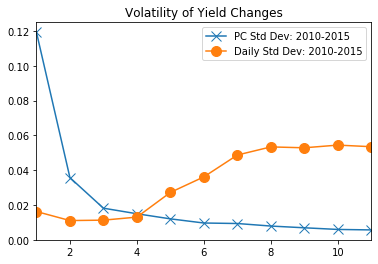

In [30]:
pca_transformed_yield.std().plot(marker='x',markersize=10,label='PC Std Dev: 2010-2015',
                                                         title='Volatility of Yield Changes')
pd.Series(yieldchanges['2010':'2015'].std().values,index=range(1,
                                                               eigen_values.shape[0]+1,1)).plot(marker='o',
                                                                                                markersize=10,
                                                                                                label='Daily Std Dev: 2010-2015'
                                                                                               )
plt.legend()

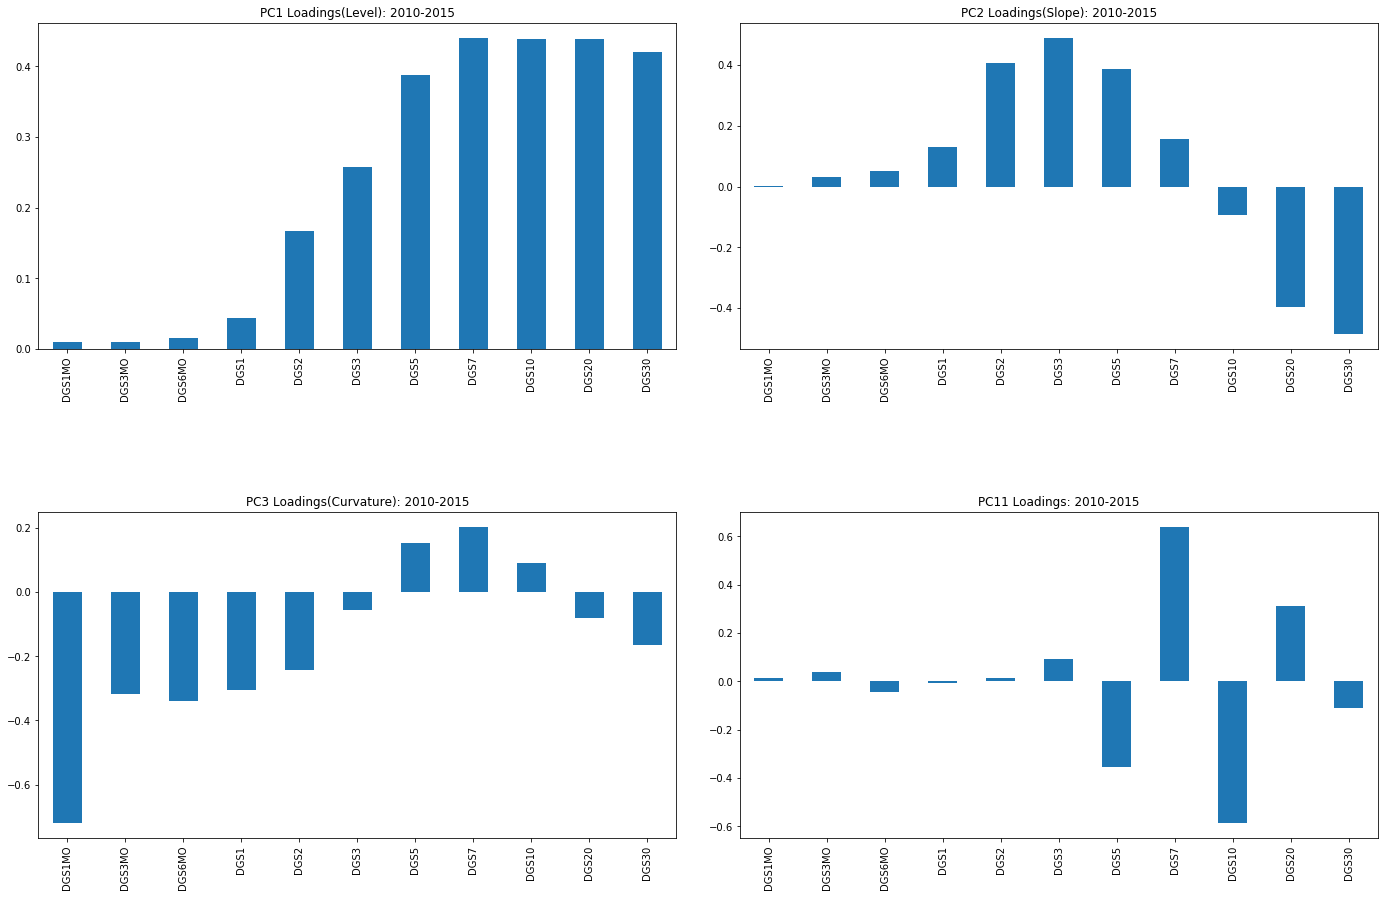

In [31]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(24,15))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
eigen_df[1].plot(ax=ax[0,0],kind="bar",title='PC1 Loadings(Level): 2010-2015')
eigen_df[2].plot(ax=ax[0,1],kind="bar",title='PC2 Loadings(Slope): 2010-2015')
eigen_df[3].plot(ax=ax[1,0],kind="bar",title='PC3 Loadings(Curvature): 2010-2015')
eigen_df[11].plot(ax=ax[1,1],kind="bar",title='PC11 Loadings: 2010-2015')

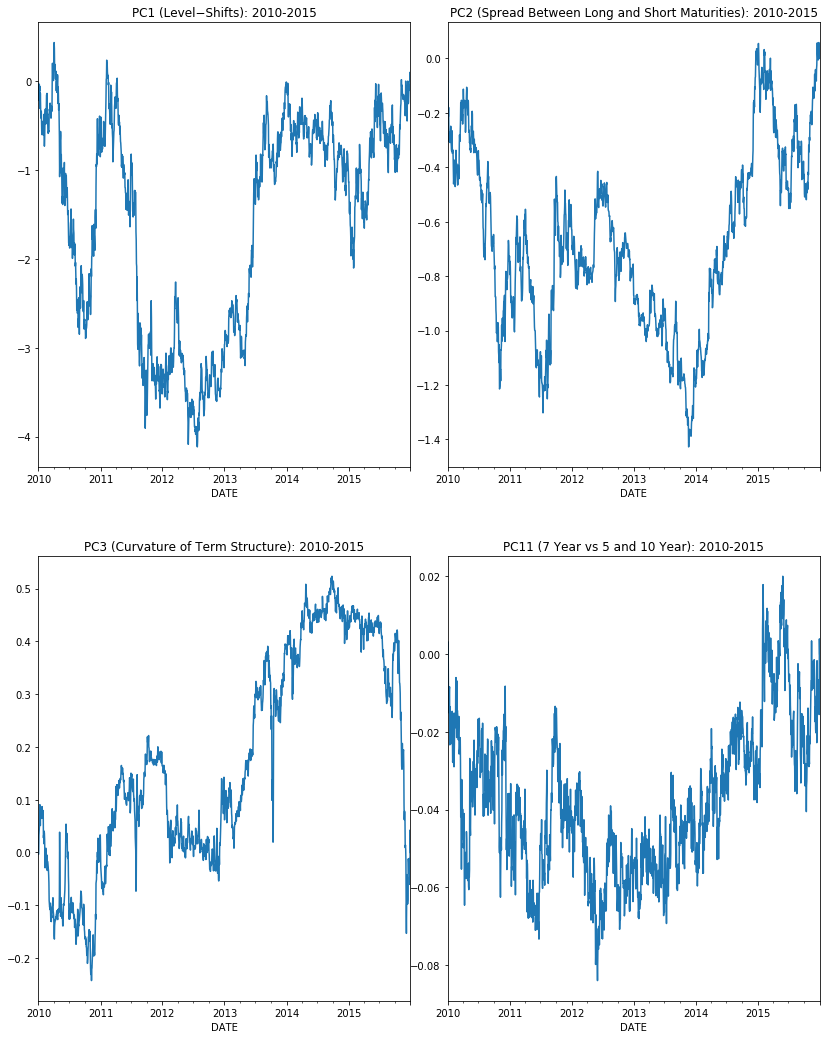

In [32]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(14,18))
plt.subplots_adjust(wspace=0.1,hspace=0.2)
pca_transformed_yield[1].cumsum().plot(ax=ax[0,0],title='PC1 (Level−Shifts): 2010-2015')
pca_transformed_yield[2].cumsum().plot(ax=ax[0,1],title='PC2 (Spread Between Long and Short Maturities): 2010-2015')
pca_transformed_yield[3].cumsum().plot(ax=ax[1,0],title='PC3 (Curvature of Term Structure): 2010-2015')
#pca_transformed_yield[10].plot(ax=ax[2,0],kind="bar",title='P10 Loadings: 2001-2005')
pca_transformed_yield[11].cumsum().plot(ax=ax[1,1],title='PC11 (7 Year vs 5 and 10 Year): 2010-2015')

## Consider 2015-Present period

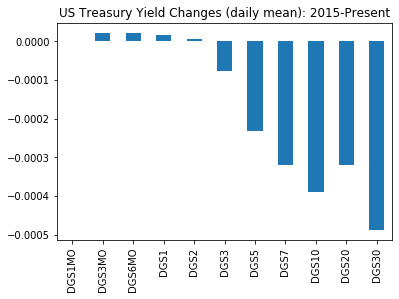

In [33]:
yieldchanges['2015':].mean().plot(kind='bar', title ='US Treasury Yield Changes (daily mean): 2015-Present')

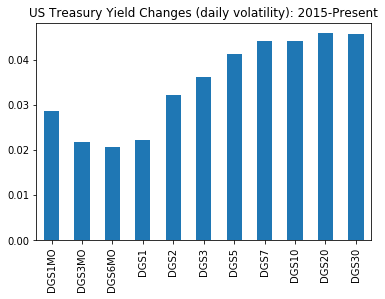

In [34]:
yieldchanges['2015':].std().plot(kind='bar', title ='US Treasury Yield Changes (daily volatility): 2015-Present')

In [35]:
yieldchanges['2015':].corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.376332,0.303530,0.230879,0.110924,0.087759,0.053195,0.035730,0.037745,0.033451,0.036900
DGS3MO,0.376332,1.000000,0.634338,0.440974,0.271022,0.249326,0.210178,0.186719,0.183931,0.166555,0.163438
DGS6MO,0.303530,0.634338,1.000000,0.634403,0.443128,0.411816,0.370696,0.333771,0.321030,0.279975,0.268012
DGS1,0.230879,0.440974,0.634403,1.000000,0.667467,0.642108,0.580272,0.533884,0.493856,0.426949,0.403506
DGS2,0.110924,0.271022,0.443128,0.667467,1.000000,0.917364,0.864658,0.805136,0.739559,0.634343,0.592507
DGS3,0.087759,0.249326,0.411816,0.642108,0.917364,1.000000,0.942240,0.896978,0.836848,0.732715,0.688520
DGS5,0.053195,0.210178,0.370696,0.580272,0.864658,0.942240,1.000000,0.967641,0.924494,0.836322,0.793369
DGS7,0.035730,0.186719,0.333771,0.533884,0.805136,0.896978,0.967641,1.000000,0.970165,0.907799,0.872549
DGS10,0.037745,0.183931,0.321030,0.493856,0.739559,0.836848,0.924494,0.970165,1.000000,0.956709,0.933354
DGS20,0.033451,0.166555,0.279975,0.426949,0.634343,0.732715,0.836322,0.907799,0.956709,1.000000,0.975055


In [36]:
pca=PCA()
yields_transformed=pca.fit_transform(yieldchanges['2015':])
eigen_vectors=pca.components_
eigen_values=pca.explained_variance_
pca_transformed_yield=pd.DataFrame(yields_transformed,
                                   columns=range(1,eigen_values.shape[0]+1,1),
                                   index=yieldchanges['2015':].index)

In [37]:
eigen_values_cumulative=pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
                                     index=range(1,eigen_values.shape[0]+1,1), columns=['Expained Var'])
eigen_df=pd.DataFrame(eigen_vectors.T,index=yieldchanges.columns, columns=range(1,eigen_values.shape[0]+1,1))
eigen_values_cumulative

,Expained Var
1,0.765277
2,0.858142
3,0.920962
4,0.953620
5,0.968479
6,0.978659
7,0.987409
8,0.992105
9,0.995214
10,0.997982


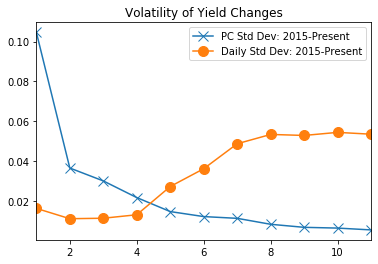

In [38]:
pca_transformed_yield.std().plot(marker='x',markersize=10,label='PC Std Dev: 2015-Present',
                                                         title='Volatility of Yield Changes')
pd.Series(yieldchanges['2010':'2015'].std().values,index=range(1,
                                                               eigen_values.shape[0]+1,1)).plot(marker='o',
                                                                                                markersize=10,
                                                                                                label='Daily Std Dev: 2015-Present'
                                                                                               )
plt.legend()

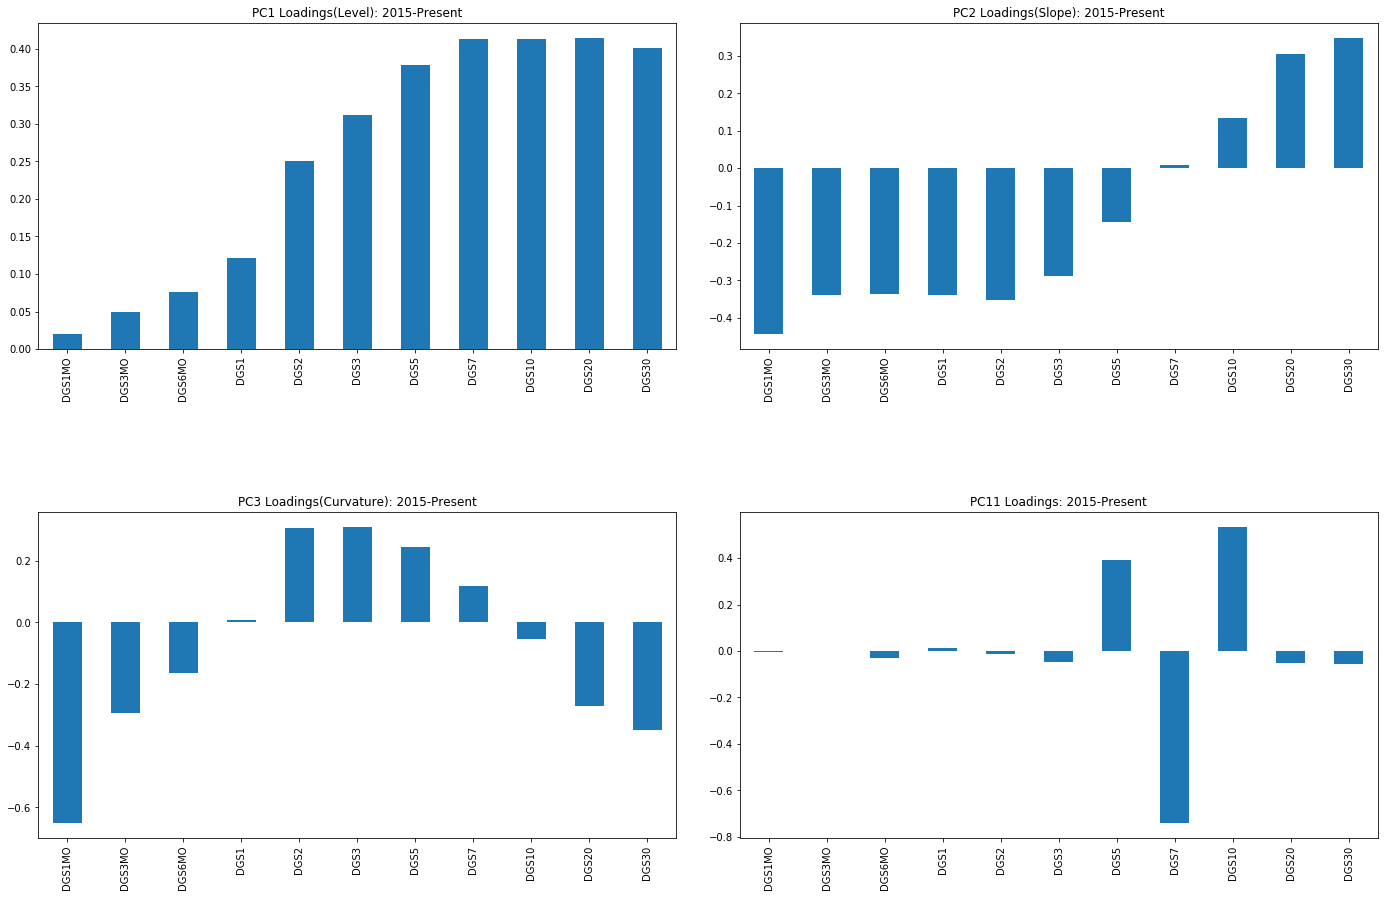

In [39]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(24,15))
plt.subplots_adjust(wspace=0.1,hspace=0.5)
eigen_df[1].plot(ax=ax[0,0],kind="bar",title='PC1 Loadings(Level): 2015-Present')
eigen_df[2].plot(ax=ax[0,1],kind="bar",title='PC2 Loadings(Slope): 2015-Present')
eigen_df[3].plot(ax=ax[1,0],kind="bar",title='PC3 Loadings(Curvature): 2015-Present')
eigen_df[11].plot(ax=ax[1,1],kind="bar",title='PC11 Loadings: 2015-Present')

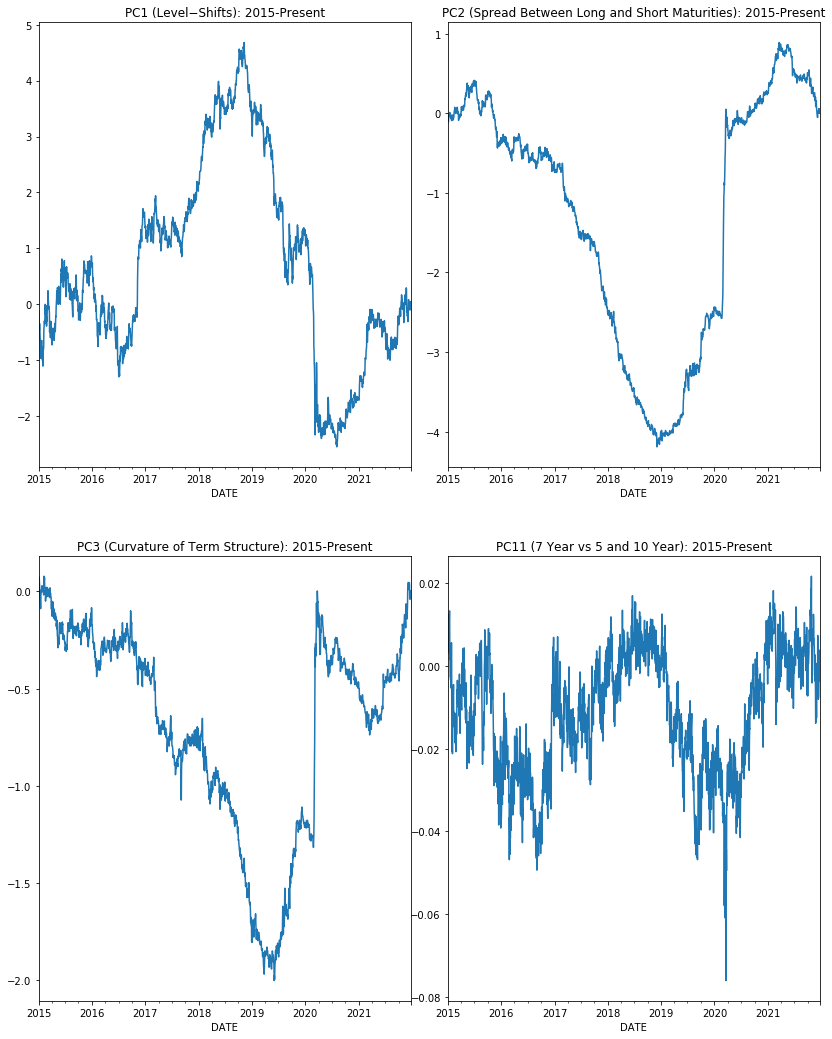

In [40]:
fig,ax=plt.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[2,2]}, figsize=(14,18))
plt.subplots_adjust(wspace=0.1,hspace=0.2)
pca_transformed_yield[1].cumsum().plot(ax=ax[0,0],title='PC1 (Level−Shifts): 2015-Present')
pca_transformed_yield[2].cumsum().plot(ax=ax[0,1],title='PC2 (Spread Between Long and Short Maturities): 2015-Present')
pca_transformed_yield[3].cumsum().plot(ax=ax[1,0],title='PC3 (Curvature of Term Structure): 2015-Present')
#pca_transformed_yield[10].plot(ax=ax[2,0],kind="bar",title='P10 Loadings: 2001-2005')
pca_transformed_yield[11].cumsum().plot(ax=ax[1,1],title='PC11 (7 Year vs 5 and 10 Year): 2015-Present')